In [1]:
#how the model was trained - saving the array as a png and then passing it through the model yields nearly the same results

In [2]:
import torch
from torch import tensor
import numpy as np
import torch.nn as nn
relu = nn.functional.relu
softmax = nn.functional.softmax
from torch.nn.functional import cross_entropy
from pathlib import Path
import os, shutil
from os import listdir
import pickle
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display

import pandas as pd
from pandas import Series, DataFrame

In [3]:
#might not work on shape (1,288,432,4)

class Model(nn.Module):

    # initializer function
    def __init__(self, input_shape=(1, 199,336), classes=9):
        super(Model, self).__init__()
        # five convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1)       
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1)
        # one dropout layer
        self.dropout = nn.Dropout(0.3)
        # one dense layer
        self.final_dense = nn.Linear(11200, classes) 

        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.batchnorm5= nn.BatchNorm2d(128)

        for m in (self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.final_dense):   #converts from default weight normalization to glorot(xavier)
            nn.init.constant_(m.bias,0)
            nn.init.xavier_normal_(m.weight, np.sqrt(2))

    # forward-pass function
    def forward(self, x):
        x = relu(self.conv1(x))     #after each convolution, pool and normalize
        x = self.pool(x)            #used to reduce dimensionality
        x = self.batchnorm1(x)
        #x = self.dropout(x)
        
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        #x = self.dropout(x)
        
        x = relu(self.conv3(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
#         x = relu(self.conv4(x))
#         x = self.pool(x)
#         x = self.batchnorm4(x)
        
#         x = relu(self.conv5(x))
#         x = self.pool(x)
#         x = self.batchnorm5(x)
        
        x = x.reshape(len(x),-1)
        x = self.dropout(x)
        x = softmax(self.final_dense(x), dim = 1)
        
        return x
    

In [4]:
def accuracy(predictions, truthdata):
    #Returns the mean classification accuracy for a batch of predictions.
    ''''
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    '''''
    return np.mean(np.argmax(predictions, axis=1) == truth) 



In [5]:

one_hots = {"blues":[1,0,0,0,0,0,0,0,0], "classical":[0,1,0,0,0,0,0,0,0], "country":[0,0,1,0,0,0,0,0,0], "disco":[0,0,0,1,0,0,0,0,0], "hiphop":[0,0,0,0,1,0,0,0,0], "metal":[0,0,0,0,0,1,0,0,0], "pop":[0,0,0,0,0,0,1,0,0], "reggae":[0,0,0,0,0,0,0,1,0],"rock":[0,0,0,0,0,0,0,0,1]}

images_dir = Path(r"C:\Users\g_bab\Downloads\audiosamples").expanduser()
labelslist = []
x_data=[]
xtest_data = []
labelslisttest = []
for fname in listdir(images_dir):
    count = 0
    counttest = 0
    iteration = 0 
    print(fname)
    for second in listdir(r"C:\Users\g_bab\Downloads\audiosamples\{}".format(fname)):
        fpath = os.path.join(images_dir, fname)
        finalpath = os.path.join(fpath, second)
        #print(finalpath)
        y, sr = librosa.load(finalpath, duration=5)
        im = librosa.feature.melspectrogram(y=y, sr=sr)  
        #print(im.shape)
        #im = np.array(im, dtype = np.float32)
        if im.shape == (128,216):
            if iteration%4 == 0:
                xtest_data.append(im)
                counttest += 1
            else:
                x_data.append(im) 
                count += 1
        iteration+=1
        #print(fname, type(fname))
    for i in range(count):
        labelslist.append(one_hots[fname])
    for i in range(counttest):
        labelslisttest.append(one_hots[fname])
        
    

finaldata = []
for arr in x_data:
    arr = arr[np.newaxis,...]
    arr = arr/255 #scaling it down
    finaldata.append(arr)
x_data = finaldata


finaltestdata = []
for arr in xtest_data:
    arr = arr[np.newaxis,...]
    arr = arr/255 #scaling it down
    finaltestdata.append(arr)
xtest_data = finaltestdata


x_train = x_data       
x_test = xtest_data


y_train = labelslist
y_test = labelslisttest

blues
classical
country
disco
hiphop
metal
pop
reggae
rock


In [6]:
print(any(ele.shape!=(1,128,216) for ele in x_train))

False


In [7]:
print(len(x_train), len(y_train))

4048 4048


In [8]:
#GPU nerd-ery
# device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# x_train = torch.tensor(x_train).to(device)
# y_train = torch.tensor(y_train, dtype=torch.int64).to(device)

# x_test = torch.tensor(x_test).to(device)
# y_test = torch.tensor(y_test, dtype=torch.int64).to(device)

<IPython.core.display.Javascript object>


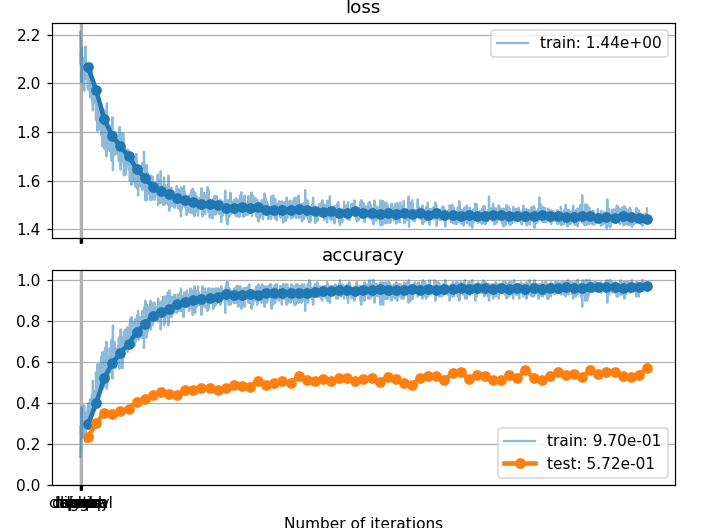

In [12]:
%matplotlib notebook
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [10]:
# x_train[1].shape
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# ax.imshow(x_train[1][44:-45, 54:-42].astype("uint8"))

In [13]:
# TRAINING SETUP

model = Model()#.to(device)
optim = torch.optim.Adam(model.parameters(), weight_decay=14e-3)
batch_size = 100 #should be 100
epochs = 70                      #recommended 70

#print(x_train[:3])

for epoch_cnt in range(epochs):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  

    for batch_cnt in range(len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = [x_train[index] for index in batch_indices]  # random batch of our training data
        #np.stack(batch)
        #print(batch[:3])
        optim.zero_grad()  #pytorch accumulates gradients
        spec = np.stack(batch)
        #print(spec.shape)
        spec = torch.tensor(spec)
        #spec = spec.double()
        
        #print(type(spec))
        # compute the predictions for this batch by calling on model
        
        prediction = model(spec)
        #print(prediction)
        #print(torch.sum(prediction))
        # compute the true (a.k.a desired) values for this batch: 
        truth = [y_train[indexes] for indexes in batch_indices]
        truth = torch.tensor(truth).argmax(dim = 1)
#         if any(tru>3 for tru in truth):
#             print(truth)
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = cross_entropy(prediction, truth) 
        
        #print(type(truth), type(prediction))
        # back-propagate through your computational graph through your loss
        loss.backward()

        # execute gradient descent by calling step() of optim
        optim.step()

        # compute the accuracy between the prediction and the truth 
        truth = truth.detach().numpy()
        prediction = prediction.detach().numpy()
        acc = accuracy(prediction, truth)

        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)

    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(x_test)//batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = [x_test[index] for index in batch_indices]

        with torch.no_grad():
            # get your model's prediction on the test-batch
            spec = np.stack(batch)
            spec = torch.tensor(spec)
            
            truth = [y_test[indexy] for indexy in batch_indices]
            truth = np.array(truth)
            truth = np.argmax(truth, axis = 1)
            #truth = truth.detach().numpy()
            
            prediction = model(spec)
            np.stack(prediction)
            prediction = prediction.detach().numpy()
            
            # get the truth values for that test-batch
            

            # compute the test accuracy
            acc = accuracy(prediction, truth)

        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()


In [30]:
print(batch[98].shape)

(1, 128, 216)


In [ ]:
print(truth.shape)

In [41]:
#can analyze song for any desired length and average to find what genre is overall most prevalent
#although since the test acc isnt so good to begin with improvement isnt much

def input_process_and_query():
    """
    docstring
    """
    genreslist = ["blues","classical","country", "disco", "hiphop", "metal", "pop", "reggae","rock"]
    
    # input filename
    filepath = input("What is the song's (full) filepath?")
    # get filepath given filename
    song = os.path.join(f"{filepath}")
    # load in 5 seconds of audio for this sound file
    
    melslist = []
    for i in range(1):    #loads the input song for range * 5 seconds
        y, sr = librosa.load(song, duration=5)
        # use time-series and sampling-rate to get mel-spectrogram as np array
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        # creates a new "Figure" (for displaying data)
        mels = mels[np.newaxis, ...]
        mels = mels/255
        melslist.append(mels)
    mels = np.stack(melslist)   
    mels = torch.tensor(mels)
    predictionsfreqs = model(mels)
    predictionsfreqs = predictionsfreqs.detach().numpy()
    predictionsfreqs = np.mean(predictionsfreqs, axis = 0)
    finalpred = genreslist[np.argmax(predictionsfreqs)]
    #could convert to probabilities here if wanted
    %matplotlib notebook
    data = predictionsfreqs.flatten()
    print(data.shape)
    plt.bar(genreslist, data)
    plt.show()
    
    return finalpred

In [36]:
# def classify_query():   
#     """
#     docstring
#     """
#     # converts spectrogram image into an array
#     image_arr = img_to_array(image) 
#     # reshapes to the same dimensions & color channels of those from training   
#     image_arr = np.reshape(image_arr,(1,288,432,4))
#     # uses GenreModel to make prediction, /255 scales rgb coefficients down for the model
#     predictions = model(image_arr/255)
#     # reshape predictions into 9 genre frequencies
#     predictionsfreqs = predictions.reshape((9,)) 
#     # gets respective labels for predictions
#     prediction_labels = np.argmax(predictions)
#     # return labels and predictions for plotting
    
#     return prediction_labels, predictionsfreqs

What is the song's (full) filepath?C:\Users\g_bab\Downloads\il vento d'oro.wav
(9,)


<IPython.core.display.Javascript object>


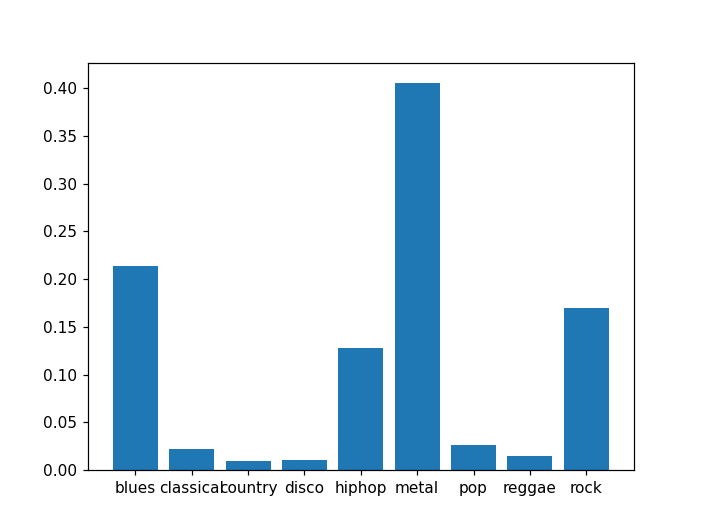

'metal'

In [46]:
input_process_and_query()